In [35]:
import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn
import datetime, pathlib, io, os, time, random, re, string
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense, Flatten, InputLayer, BatchNormalization, Input, Embedding, TextVectorization
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dropout, Conv1D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

In [2]:
BATCH_SIZE = 64

# Load Dataset

In [3]:
train_ds, val_ds, test_ds = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)

# Text Standardization

In [4]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_tag = tf.strings.regex_replace(lowercase, "<[^>]+>", "")
    output = tf.strings.regex_replace(no_tag, "[%s]"%re.escape(string.punctuation), "")
    return output

# Tokenization

In [5]:
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 250

In [6]:
vectorize_layer = TextVectorization(
    standardize= standardization,
    max_tokens = VOCAB_SIZE,
    output_mode = 'int',
    output_sequence_length = SEQUENCE_LENGTH
)

### vocaburary

In [7]:
training_data = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(training_data)

In [8]:
len(vectorize_layer.get_vocabulary())

10000

In [8]:
def vectorizer(review, label):
    return vectorize_layer(review), label

In [10]:
for review, label in train_ds.take(1):
    print(review, label)
    print(vectorizer(review, label))

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
(<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  10,   13,   33,  411,  384,   17,   89,   26,    1,    8,   32,
       1337, 3521,   40,  491,    1,  192,   22,   84,  149,   18,   10,
        215,  317,   26

### vectorized dataset

In [9]:
train_dataset = train_ds.map(vectorizer)
val_dataset = val_ds.map(vectorizer)

In [ ]:
for review, label in train_dataset.take(1):
    print(review, label)

In [10]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

In [ ]:
inputs = np.random.random([32, 10, 8]) # Batch, Sequence, Vocabulary(Embedding)
simple_rnn = tf.keras.layers.SimpleRNN(4) # Output and Cell State's Dimension

output = simple_rnn(inputs)
print(output.shape)

In [13]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)), # TextVectorization's output_mode is int
    Embedding(VOCAB_SIZE, EMBEDDING_DIM), # Embedding's input is one-hot
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643,137
Trainable params: 643,137
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_filepath = 'localdata/Section5/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
10/10 [==============================] - 2s 109ms/step - loss: 0.6973 - accuracy: 0.4797 - val_loss: 0.6958 - val_accuracy: 0.4516
Epoch 2/10
10/10 [==============================] - 1s 99ms/step - loss: 0.6226 - accuracy: 0.7078 - val_loss: 0.6991 - val_accuracy: 0.4906
Epoch 3/10
10/10 [==============================] - 1s 75ms/step - loss: 0.5212 - accuracy: 0.8328 - val_loss: 0.7089 - val_accuracy: 0.4906
Epoch 4/10
10/10 [==============================] - 1s 108ms/step - loss: 0.4049 - accuracy: 0.9078 - val_loss: 0.7116 - val_accuracy: 0.5031
Epoch 5/10
10/10 [==============================] - 1s 98ms/step - loss: 0.3497 - accuracy: 0.9344 - val_loss: 0.7222 - val_accuracy: 0.5172
Epoch 6/10
10/10 [==============================] - 1s 74ms/step - loss: 0.2698 - accuracy: 0.9656 - val_loss: 0.7550 - val_accuracy: 0.4906
Epoch 7/10
10/10 [==============================] - 1s 76ms/step - loss: 0.2149 - accuracy: 0.9797 - val_loss: 0.7615 - val_accuracy: 0.5031
Epoch 8/10


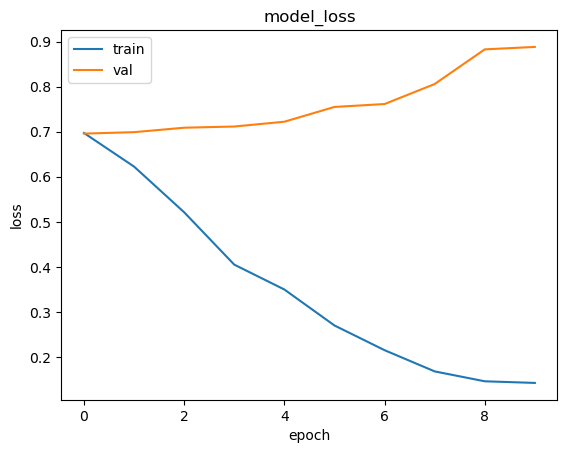

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

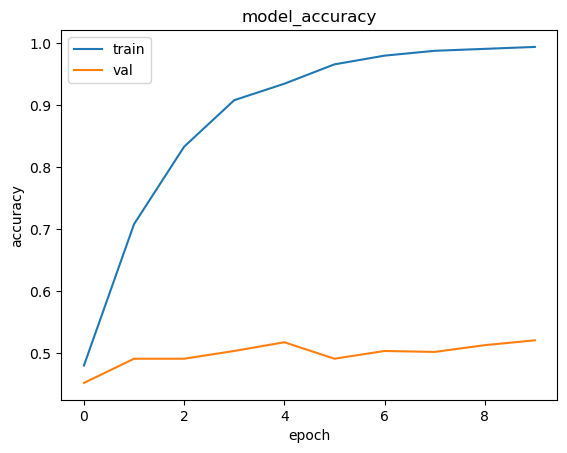

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Advanced RNNs (LSTM and GRU)

## LSTM (Multi-Layer and Bidirectional)

In [25]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)), # TextVectorization's output_mode is int
    Embedding(VOCAB_SIZE, EMBEDDING_DIM), # Embedding's input is one-hot
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 250, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=10)

Epoch 1/10
10/10 [==============================] - 19s 1s/step - loss: 0.6929 - accuracy: 0.5172 - val_loss: 0.6932 - val_accuracy: 0.5047
Epoch 2/10
10/10 [==============================] - 9s 918ms/step - loss: 0.6919 - accuracy: 0.5437 - val_loss: 0.6933 - val_accuracy: 0.5047
Epoch 3/10
10/10 [==============================] - 9s 867ms/step - loss: 0.6817 - accuracy: 0.5828 - val_loss: 0.6901 - val_accuracy: 0.5078
Epoch 4/10
10/10 [==============================] - 8s 756ms/step - loss: 0.5915 - accuracy: 0.7719 - val_loss: 0.6371 - val_accuracy: 0.6422
Epoch 5/10
10/10 [==============================] - 8s 800ms/step - loss: 0.3010 - accuracy: 0.9266 - val_loss: 1.0011 - val_accuracy: 0.6156
Epoch 6/10
10/10 [==============================] - 8s 828ms/step - loss: 0.1820 - accuracy: 0.9375 - val_loss: 0.7302 - val_accuracy: 0.6469
Epoch 7/10
10/10 [==============================] - 8s 792ms/step - loss: 0.1013 - accuracy: 0.9766 - val_loss: 1.0540 - val_accuracy: 0.6609
Epoch 8/

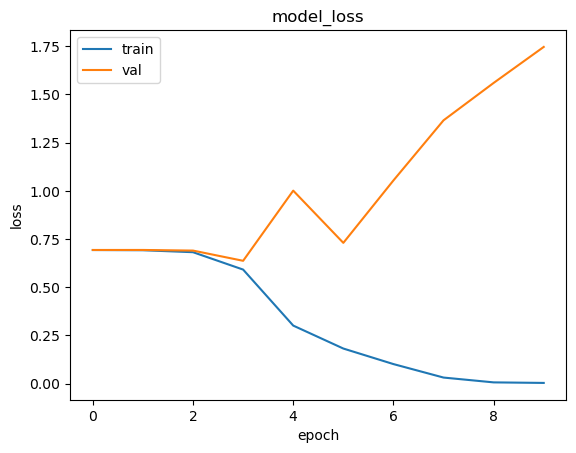

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

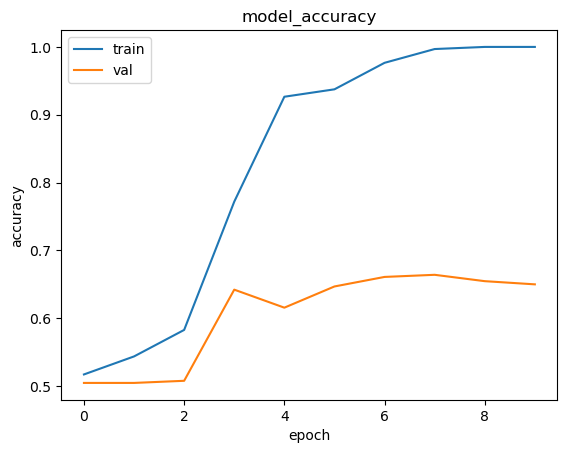

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## GRU

In [30]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)), # TextVectorization's output_mode is int
    Embedding(VOCAB_SIZE, EMBEDDING_DIM), # Embedding's input is one-hot
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 250, 128)         49920     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
history = model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=10)

Epoch 1/10
10/10 [==============================] - 18s 888ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5047
Epoch 2/10
10/10 [==============================] - 7s 658ms/step - loss: 0.6882 - accuracy: 0.5609 - val_loss: 0.6927 - val_accuracy: 0.5094
Epoch 3/10
10/10 [==============================] - 6s 605ms/step - loss: 0.6744 - accuracy: 0.6109 - val_loss: 0.6902 - val_accuracy: 0.5203
Epoch 4/10
10/10 [==============================] - 7s 706ms/step - loss: 0.6190 - accuracy: 0.7484 - val_loss: 0.6891 - val_accuracy: 0.5531
Epoch 5/10
10/10 [==============================] - 6s 613ms/step - loss: 0.4317 - accuracy: 0.8375 - val_loss: 0.8716 - val_accuracy: 0.5891
Epoch 6/10
10/10 [==============================] - 7s 662ms/step - loss: 0.1699 - accuracy: 0.9359 - val_loss: 1.1198 - val_accuracy: 0.5922
Epoch 7/10
10/10 [==============================] - 6s 621ms/step - loss: 0.0606 - accuracy: 0.9828 - val_loss: 1.3607 - val_accuracy: 0.5813
Epoch

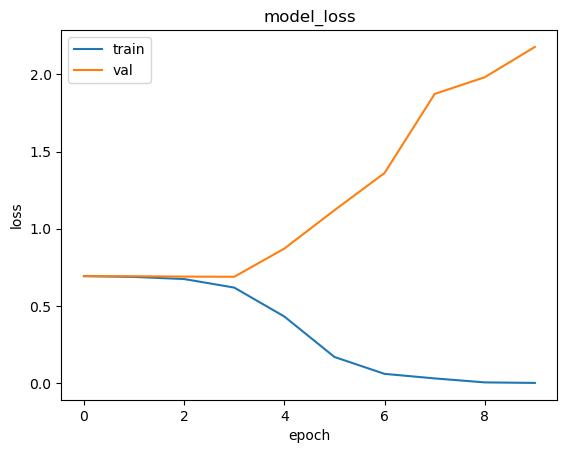

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

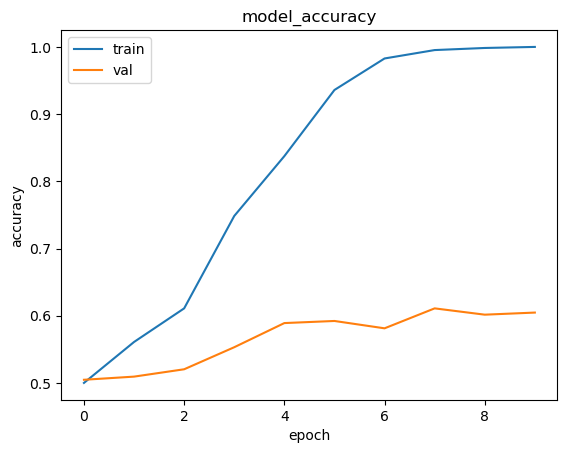

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 1D Convolutional Neural Network

In [44]:
conv1d = Conv1D(1, 3, 1, "valid")
i = tf.random.uniform([32, 4, 8]) # Embedding is channel like RGB
print(i.shape)
o = conv1d(i)
print(o.shape)

cm = tf.keras.models.Sequential([
    conv1d
])
cm(i)
cm.summary()

(32, 4, 8)
(32, 2, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (32, 2, 1)                25        
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'Conv1D' object has no attribute 'summary'

In [45]:
EMBEDDING_DIM = 64
model = tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)), # TextVectorization's output_mode is int
    Embedding(VOCAB_SIZE, EMBEDDING_DIM), # Embedding's input is one-hot
    Conv1D(32, 3, activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           640000    
                                                                 
 conv1d_4 (Conv1D)           (None, 248, 32)           6176      
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                253984    
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 900,193
Trainable params: 900,193
Non-tr

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
history = model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 106ms/step - loss: 0.6967 - accuracy: 0.4812 - val_loss: 0.6918 - val_accuracy: 0.5047
Epoch 2/10
10/10 [==============================] - 1s 72ms/step - loss: 0.6709 - accuracy: 0.6344 - val_loss: 0.6921 - val_accuracy: 0.4969
Epoch 3/10
10/10 [==============================] - 1s 75ms/step - loss: 0.6457 - accuracy: 0.6859 - val_loss: 0.6930 - val_accuracy: 0.5359
Epoch 4/10
10/10 [==============================] - 1s 72ms/step - loss: 0.5911 - accuracy: 0.7828 - val_loss: 0.6963 - val_accuracy: 0.5250
Epoch 5/10
10/10 [==============================] - 1s 78ms/step - loss: 0.4769 - accuracy: 0.9203 - val_loss: 0.6923 - val_accuracy: 0.5453
Epoch 6/10
10/10 [==============================] - 1s 72ms/step - loss: 0.3367 - accuracy: 0.9516 - val_loss: 0.6990 - val_accuracy: 0.5297
Epoch 7/10
10/10 [==============================] - 1s 72ms/step - loss: 0.2062 - accuracy: 0.9859 - val_loss: 0.7025 - val_accuracy: 0.5391
Epoch 8/10
1

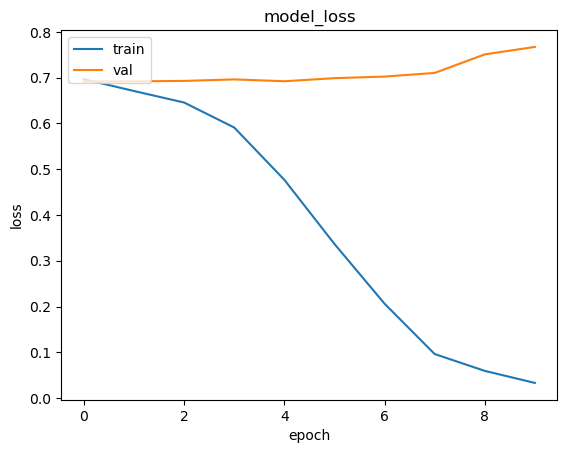

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

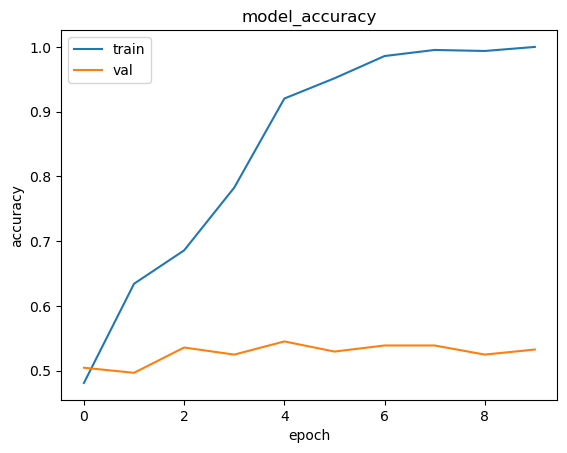

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()